    Loading libraries and data:

In [1]:
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
import re

In [ ]:
df = pd.read_csv(r'spam.csv')

    Preprocessing:

In [3]:
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.info

<bound method DataFrame.info of      label                                                sms
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham              Will Ì_ b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>

In [3]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sms'])
sequences = tokenizer.texts_to_sequences(df['sms'])

# Pad sequences to a fixed length
max_words = 50
X = pad_sequences(sequences, maxlen=max_words)
y = df['label']

In [4]:
embedding_size = 32

# Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_size, input_length=max_words))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            285472    
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 302,123
Trainable params: 302,123
Non-trainable params: 0
_________________________________________________________________
None


    Model Training:

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
batch_size = 64
num_epochs = 5
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs)

Epoch 1/5
70/70 [==============================] - 6s 43ms/step - loss: 0.3244 - accuracy: 0.8874 - val_loss: 0.1339 - val_accuracy: 0.9695
Epoch 2/5
70/70 [==============================] - 2s 34ms/step - loss: 0.0719 - accuracy: 0.9838 - val_loss: 0.0740 - val_accuracy: 0.9812
Epoch 3/5
70/70 [==============================] - 3s 36ms/step - loss: 0.0315 - accuracy: 0.9924 - val_loss: 0.0821 - val_accuracy: 0.9776
Epoch 4/5
70/70 [==============================] - 2s 28ms/step - loss: 0.0181 - accuracy: 0.9951 - val_loss: 0.0543 - val_accuracy: 0.9848
Epoch 5/5
70/70 [==============================] - 2s 24ms/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0643 - val_accuracy: 0.9848


In [6]:
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.9847533702850342


    Visualization:

Epoch 1/5
70/70 [==============================] - 3s 38ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.0622 - val_accuracy: 0.9857
Epoch 2/5
70/70 [==============================] - 2s 32ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0721 - val_accuracy: 0.9821
Epoch 3/5
70/70 [==============================] - 2s 32ms/step - loss: 9.6942e-04 - accuracy: 1.0000 - val_loss: 0.0694 - val_accuracy: 0.9848
Epoch 4/5
70/70 [==============================] - 2s 33ms/step - loss: 6.8966e-04 - accuracy: 1.0000 - val_loss: 0.0741 - val_accuracy: 0.9857
Epoch 5/5
70/70 [==============================] - 2s 32ms/step - loss: 4.9357e-04 - accuracy: 1.0000 - val_loss: 0.0755 - val_accuracy: 0.9865
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


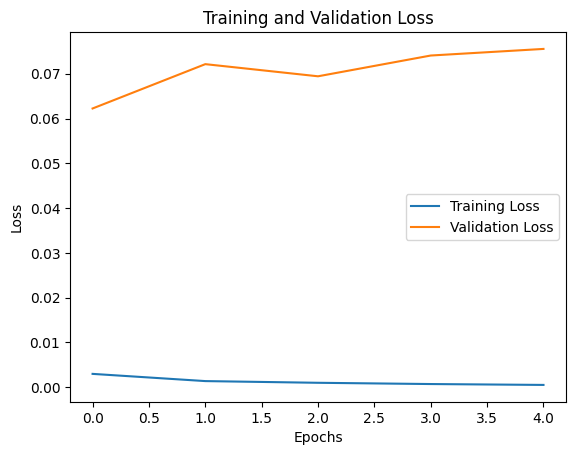

In [25]:
from keras.callbacks import History

# Create a history object to save training history
history = History()

# Train the model with history callback
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=num_epochs, callbacks=[history])

# Check available keys in history object
print(history.history.keys())

# Plot training and validation loss if available
if 'loss' in history.history and 'val_loss' in history.history:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("Loss data not available in history.")


    Real-time Prediction:

In [8]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def predict_spam_or_ham(input_text, model, tokenizer, max_words):
    # Preprocess the input text
    processed_text = preprocess_text(input_text)
    # Tokenize and pad the processed text
    sequence = tokenizer.texts_to_sequences([processed_text])
    input_sequence = pad_sequences(sequence, maxlen=max_words)
    # Perform prediction using the model
    prediction = model.predict(input_sequence)
    # Map prediction probabilities to label
    if prediction[0][0] >= 0.5:
        label = 'spam'
    else:
        label = 'ham'
    return label

input_text = input('Enter Input to check for spam/ham:')
prediction = predict_spam_or_ham(input_text, model, tokenizer, max_words)
print("Predicted label:", prediction)

1/1 [==============================] - 0s 40ms/step
Predicted label: ham
